In [1]:
import torch
from torchvision import models, transforms
import torch.optim as optimizers
from PIL import Image
import numpy
import matplotlib.pyplot as pyplot
from IPython import display
import numpy as np

In [2]:
model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.DEFAULT)

#freezing parameters -> nur target soll verändert werden
for parameter in model.parameters():
    parameter.requires_grad_(False) #only optimize target image, not the other parameters

torch_device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu") #use gpu if possible

model.to(torch_device)

#Hinweis: Bild MUSS quadratisch sein
def load_image(path_to_image, shape=None):
    loaded_image = Image.open(path_to_image).convert("RGB")

    # Bigger pictures will slow down the training process
    MAXIMUM_SIZE = 500
    if max(loaded_image.size) > MAXIMUM_SIZE:
        size = (MAXIMUM_SIZE, MAXIMUM_SIZE)
    else:
        size = loaded_image.size

    if shape is not None:
        size = shape #.size gibt eh schon ein Tupel zurück

    image_transformations = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.495, 0.455, 0.405),
                             (0.255, 0.220, 0.230))
    ])

    loaded_image = image_transformations(loaded_image)[:3, :, :].unsqueeze(0)

    return loaded_image

In [3]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [4]:
original_image = load_image('imgs/women.jpg').to(torch_device) #bilder zum torch.device schicken
style_image = load_image("styleimages/VanGogh/starry_night.jpg", shape=original_image.shape[-2:]).to(torch_device) #Style Bild soll genau die gleiche Shape haben, wie das Orginalbild

#visualize the image after tranformation
def display_image(tensor_image):
    image_to_show = tensor_image.to("cpu").clone().detach() #Kopie erzeugen
    
    image_to_show = image_to_show.numpy().squeeze()  #undo unsqueeze()
    image_to_show = image_to_show.transpose(1, 2, 0)
    image_to_show = image_to_show * numpy.array((0.255, 0.220, 0.230)) + numpy.array((0.495, 0.455, 0.405)) #unnormalize the image
    image_to_show = image_to_show.clip(0, 1) #numpy.clip -> clips the edges
    
    return image_to_show

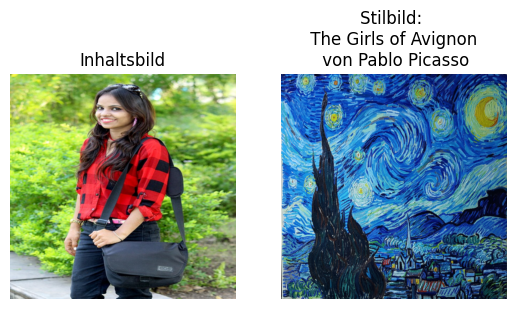

In [5]:
axis1 = pyplot.subplot(121)
axis1.set_title("Inhaltsbild")
pyplot.axis('off')
axis1.imshow(display_image(original_image))
axis2 = pyplot.subplot(122)
axis2.set_title("Stilbild: \n The Girls of Avignon \n von Pablo Picasso")
axis2.imshow(display_image(style_image))
pyplot.axis('off')
pyplot.savefig("Eingabebilder18.png")
#ensures that we didnt make a mistake by processing the images

In [6]:
#for name, layer in model.named_modules():
    #print(name)

In [7]:
def extract_features(image, model, layers=None):
    if layers is None:
        layers = {
     "layer1.0.conv2",
     "layer2.0.conv2",
     "layer3.0.conv2",
     "layer3.3.conv2",
     "layer4.0.conv1", 
     "layer4.2.conv2",
        }

    features = {}

    def hook_function(module, input, output, layer_name):
        features[layer_name] = output

    hooks = []
    for name, layer in model.named_modules():
        if name in layers:
            def apply_hook(module, input, output, name=name):
                hook_function(module, input, output, name)
            hook = layer.register_forward_hook(apply_hook)
            hooks.append(hook)

    model(image)

    for hook in hooks:
        hook.remove()

    return features

In [8]:
original_features = extract_features(original_image, model)
style_features = extract_features(style_image, model)

In [9]:
def calculate_gram_matrix(tensor_image):
    batch_size, depth, height, width = tensor_image.size()

    tensor_image = tensor_image.view(depth, -1)

    gram_matrix = torch.mm(tensor_image, tensor_image.t()) #multiply by the transposed image

    return gram_matrix

In [10]:
style_gram_matrices = {layer: calculate_gram_matrix(style_features[layer]) for layer in style_features}#calculate gram_matrix for every layer
altered_image = original_image.clone().requires_grad_(True).to(torch_device)

In [11]:
#optimize model (the heigher the weight, the larger the effect. Higher Weight on early layers mean larger style artifacts
# -> more emphathsis on larger features then smaller ones)
style_weights = {
         "layer1.0.conv2": 1.,
         "layer2.0.conv2": 0.7,
         "layer3.0.conv2": 0.5,
         "layer3.3.conv2": 0.3,
         "layer4.2.conv2": 0.1
}

optimizer = optimizers.Adam([altered_image]) #can try different ones than Adam

original_image_weight = 1 #is typically recommanded to be 1

style_image_weight = 100000 #high value! but can try different ones

In [12]:
def compute_total_variation_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

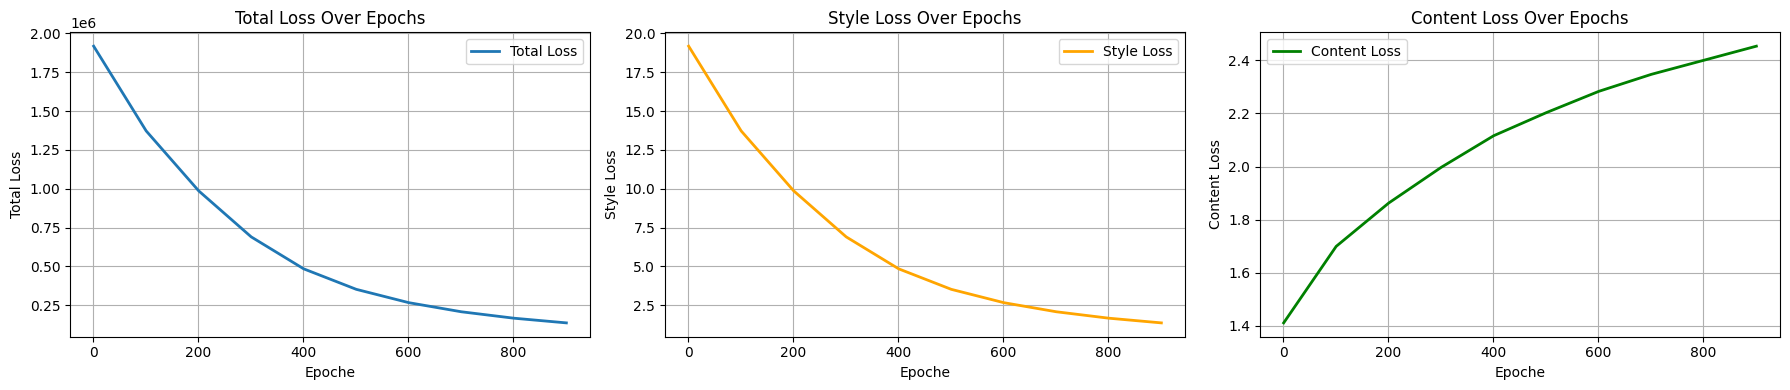

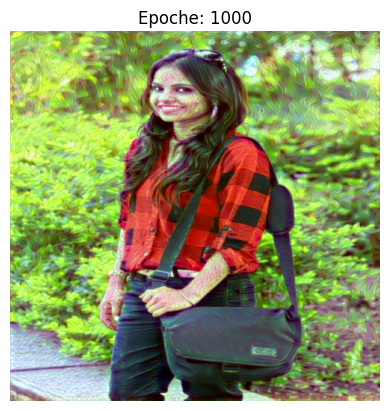

CPU times: user 31.8 s, sys: 3.98 s, total: 35.8 s
Wall time: 24 s


In [13]:
%%time
total_loss_for_plt = []  # Initialize an empty list to store total losses
style_loss_for_plt = []  # Initialize an empty list to store style losses
content_loss_for_plt = []  # Initialize an empty list to store content losses

NUMBER_OF_EPOCHS = 1000  # Can change this

for index in range(1, NUMBER_OF_EPOCHS+1):
    altered_features = extract_features(altered_image, model)  # Extract features at every epoch

    style_loss = 0

    original_image_loss = torch.mean((altered_features["layer4.0.conv1"] - original_features["layer4.0.conv1"]) ** 2)  # Mean squared error

    for layer in style_weights:
        altered_feature = altered_features[layer] #get the feature for every single weight

        altered_gram_matrix = calculate_gram_matrix(altered_feature)

        style_matrix = style_gram_matrices[layer]

        layer_style_loss = torch.mean((altered_gram_matrix - style_matrix) ** 2) * style_weights[layer] #mean squared error * layer_weight

        _, depth, height, width = altered_feature.shape

        style_loss += layer_style_loss / (depth * height * width)

    total_loss = original_image_loss * original_image_weight + style_loss * style_image_weight

    optimizer.zero_grad()

    total_loss.backward()

    optimizer.step()

    if index % 100 == 0:
        display.clear_output(wait=True)

        total_loss_for_plt.append(total_loss.detach().cpu().item())  # Append the total loss to the list
        style_loss_for_plt.append(style_loss.detach().cpu().item())  # Append the style loss to the list
        content_loss_for_plt.append(original_image_loss.detach().cpu().item())  # Append the content loss to the list

        # Create subplots
        fig, axes = pyplot.subplots(1, 3, figsize=(18, 4))

        # Plot total loss
        axes[0].plot(np.arange(1, index + 1, 100), total_loss_for_plt, label='Total Loss', linewidth=2.0)
        axes[0].set_xlabel("Epoche")
        axes[0].set_ylabel("Total Loss")
        axes[0].set_title("Total Loss Over Epochs")
        axes[0].legend()
        axes[0].grid(True)

        # Plot style loss
        axes[1].plot(np.arange(1, index + 1, 100), style_loss_for_plt, label='Style Loss', linewidth=2.0, color='orange')
        axes[1].set_xlabel("Epoche")
        axes[1].set_ylabel("Style Loss")
        axes[1].set_title("Style Loss Over Epochs")
        axes[1].legend()
        axes[1].grid(True)

        # Plot content loss
        axes[2].plot(np.arange(1, index + 1, 100), content_loss_for_plt, label='Content Loss', linewidth=2.0, color='green')
        axes[2].set_xlabel("Epoche")
        axes[2].set_ylabel("Content Loss")
        axes[2].set_title("Content Loss Over Epochs")
        axes[2].legend()
        axes[2].grid(True)

        pyplot.tight_layout()
        if index == NUMBER_OF_EPOCHS:
            pyplot.savefig("Graphen.png")
        pyplot.show()

        pyplot.imshow(display_image(altered_image))
        pyplot.title("Epoche: " + str(index))
        pyplot.axis('off')
        if index == NUMBER_OF_EPOCHS:
            pyplot.savefig("Ausgabebild18.png")
        pyplot.show()